#Sequence Labeling

Sequence Labeling을 하기 위해서는 양방향 RNN(many to many)을 사용해야 한다.

Sequence Labeling에는 개체명 인식 (Name Entitiy Recognition)과 품사 태깅 (POS Tagging)을 해보자.

여기서 Tagging은 Supervised Learning에 속한다. X_train이 'European'이라면, y_train은 'B-ORG'(Beginning of Organization)으로 태깅이 될 것이다.

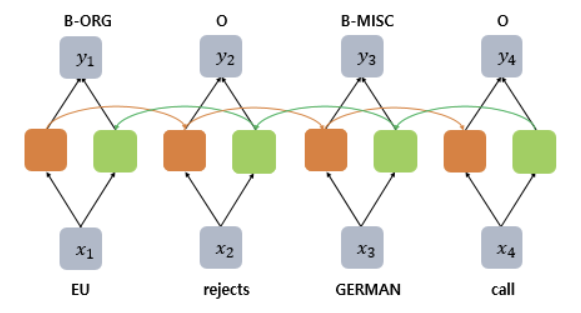

#Named Entity Recognition

NLTK 라이브러리의 개채명 인식기를 사용해보자

In [1]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

개채명 인식을 하기 위해 사용할 모듈 ne_chunk는 POS tagging이 완료된 데이터에 대해 적용할 수 있다.

 pos_tag을 통해 품사 태깅

In [2]:
from nltk import word_tokenize, pos_tag, ne_chunk

sentence = "James is working at Disney in London"

tokenized_sentence = pos_tag(word_tokenize(sentence))
print(tokenized_sentence)

[('James', 'NNP'), ('is', 'VBZ'), ('working', 'VBG'), ('at', 'IN'), ('Disney', 'NNP'), ('in', 'IN'), ('London', 'NNP')]


ne_chunk를 통해 개채명 인식하

In [3]:
ner_sentence = ne_chunk(tokenized_sentence)
print(ner_sentence)

(S
  (PERSON James/NNP)
  is/VBZ
  working/VBG
  at/IN
  (ORGANIZATION Disney/NNP)
  in/IN
  (GPE London/NNP))


#양방향 LSTM으로 개채명 인식 모델 만들

In [4]:
import urllib.request
import numpy as np
from tqdm import tqdm
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20RNN%20Sequence%20Labeling/dataset/train.txt", filename="train.txt")


('train.txt', <http.client.HTTPMessage at 0x7cceecc77a60>)

훈련 데이터의 문장 샘플 수 확인하기

In [6]:
f = open('train.txt', 'r')
time = 0
for line in f:
  if(time==10):
    break
  print(line)
  time+=1


-DOCSTART- -X- -X- O



EU NNP B-NP B-ORG

rejects VBZ B-VP O

German JJ B-NP B-MISC

call NN I-NP O

to TO B-VP O

boycott VB I-VP O

British JJ B-NP B-MISC

lamb NN I-NP O



각 line의 마지막에 named entity recognition y값이 들어있다.

In [7]:
tagged_sentences = []
sentence = []

for line in f:
  #필요없는 데이터 없애기
  if (len(line)==0 or line.startswith('-DOCSTART') or line[0]=='\n'):
    if(len(sentence)>0):
      tagged_sentences.append(sentence)
      sentence = []
    continue
  splits = line.split(' ')
  splits[-1] = re.sub(r'\n', '', splits[-1]) #개행 문자 없애기
  word = splits[0].lower() #단어는 소문자로
  sentence.append([word, splits[-1]]) #단어와 개체명 인식 결과만

print("전체 데이터 개수: ", len(tagged_sentences))


전체 데이터 개수:  14040


In [8]:
print(tagged_sentences[0])

[['peter', 'B-PER'], ['blackburn', 'I-PER']]


x값과 y값 분리

In [9]:
sentences, ner_tags = [],[]
for tagged_sentence in tagged_sentences:
  sentence, tag_info = zip(*tagged_sentence) #분리
  sentences.append(list(sentence))
  ner_tags.append(list(tag_info))

print(sentences[0])
print(ner_tags[0])


['peter', 'blackburn']
['B-PER', 'I-PER']


훈련, 테스트 데이터 분리

In [10]:
x_train, x_test, y_train, y_test = train_test_split(sentences, ner_tags, test_size=0.2, random_state=100)


훈련, 검증 데이터 분리

In [11]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state=100)

In [12]:
print('훈련 데이터의 개수 :', len(x_train))
print('검증 데이터의 개수 :', len(x_valid))
print('테스트 데이터의 개수 :', len(x_test))
print('훈련 데이터 레이블의 개수 :', len(y_train))
print('검증 데이터 레이블의 개수 :', len(y_valid))
print('테스트 데이터 레이블의 개수 :', len(y_test))


훈련 데이터의 개수 : 8985
검증 데이터의 개수 : 2247
테스트 데이터의 개수 : 2808
훈련 데이터 레이블의 개수 : 8985
검증 데이터 레이블의 개수 : 2247
테스트 데이터 레이블의 개수 : 2808


vocabulary 만들기

In [13]:
vocab = []
for sentence in x_train:
  for word in sentence:
    vocab.append(word)
word_counts = Counter(vocab)

In [14]:
word_counts

Counter({'"': 1439,
         'just': 74,
         'one': 172,
         'of': 2495,
         'those': 34,
         'things': 10,
         ',': 4660,
         'i': 190,
         'was': 731,
         'trying': 19,
         'to': 2216,
         'make': 32,
         'contact': 9,
         'said': 1170,
         'bragg': 1,
         '.': 4695,
         'defenders': 7,
         '-': 803,
         'stephane': 4,
         'henchoz': 1,
         '(': 1793,
         'hamburg': 11,
         ')': 1799,
         'marc': 9,
         'hottiger': 1,
         'everton': 5,
         'yvan': 1,
         'quentin': 1,
         'sion': 7,
         'ramon': 3,
         'vega': 1,
         'cagliari': 1,
         'raphael': 4,
         'wicky': 1,
         '29.': 1,
         'macedonia': 3,
         '8.07': 1,
         '4.': 42,
         'herve': 1,
         'thuet': 1,
         'france': 84,
         '1:04.732': 1,
         'alloy': 3,
         'shipments': 8,
         'however': 18,
         'were': 307,
  

In [15]:
word_counts['is']

456

In [16]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print(vocab[:10])

['the', '.', ',', 'of', 'in', 'to', 'a', 'and', ')', '(']


In [17]:
word2index = {}
word2index['<PAD>']=0
word2index['<UNK>']=1

#vocab 단어들 정수 인코딩
for index, word in enumerate(vocab):
  word2index[word] = index + 2


문장을 word2index에서 정한 인코딩 정수의 배열로 만들어주는 함수 구현

In [18]:
def text2sequences(tokenized_x, word2index):
  encoded_x = []
  for sentence in tokenized_x:
    index_sequences = []
    for word in sentence:
      try:
        index_sequences.append(word2index[word])
      except KeyError:
        index_sequences.append(word2index['<UNK>'])
    encoded_x.append(index_sequences)
  return encoded_x


모든 입력 데이터 모두 정수 인코딩

In [19]:
encoded_x_train = text2sequences(x_train, word2index)
encoded_x_valid = text2sequences(x_valid, word2index)
encoded_x_test = text2sequences(x_test, word2index)

In [20]:
print(encoded_x_train)

[[12, 172, 76, 5, 429, 1450, 4, 66, 19, 172, 806, 7, 450, 1601, 4, 12, 14, 8215, 3, 12], [2005, 18, 3204, 8216, 11, 1319, 10, 4, 1602, 8217, 11, 2700, 10, 4, 8218, 8219, 11, 2006, 10, 4, 4038, 8220, 11, 8221, 10, 3205, 8222, 11, 2006, 10, 3], [8223, 4039, 8224], [335, 8225, 8226, 11, 143, 10, 8227], [4040, 1771, 4, 851, 4, 43, 2701, 69, 168, 3], [20, 2, 1451, 62, 29, 36, 2, 686, 3, 12], [52, 469, 154, 2702, 4041], [760, 375, 365, 5415, 46], [3206, 2007, 4042, 177, 196], [1320, 131], [3207, 4, 1452, 210], [45, 322, 2703, 2704, 5416, 451, 13, 430, 6, 2, 78, 197, 32, 8, 1138, 5417, 33, 211, 652, 1453, 3], [114, 78, 283, 11, 1139, 4043, 10], [2705, 22, 11, 5418, 8228, 4, 8229, 3208, 10, 2290, 21, 3], [1228, 18, 5419, 11, 3209, 9, 5420, 353, 10, 4, 5421, 11, 5422, 10, 4, 8230, 11, 4044, 10, 4, 418, 1321, 8231, 11, 4045, 10], [40, 8, 119, 5, 4046, 8232, 2706, 2703, 110, 602, 4047, 2291, 30, 2, 8233, 852, 4, 200, 724, 35, 157, 622, 1772, 7, 2, 947, 7, 8234, 12, 2707, 12, 8, 1229, 6, 2, 254, 1

정수를 다시 단어로 decoding 해주는 dictionary 정의

In [21]:
index2word = {}
for key, value in word2index.items():
  index2word[value] = key


레이블 y도 정수 인코딩하기

In [22]:
tags = [tag for sentence in y_train for tag in sentence]
tags_vocab = list(set(tags))
tag2index = {}
tag2index['<PAD>'] = 0
for index, word in enumerate(tags_vocab):
  tag2index[word] = index+1


many to many RNN을 이용하기 때문에 y(Named entity label)를 sequence data로 바꾸어줘야한다.



In [23]:
def encoding_label(sequence, tag2index):
  label_sequence = []
  for seq in sequence:
    label_sequence.append([tag2index[tag] for tag in seq])
  return label_sequence


In [24]:
encoded_y_train = encoding_label(y_train, tag2index)
encoded_y_valid = encoding_label(y_valid, tag2index)
encoded_y_test = encoding_label(y_test, tag2index)


In [25]:
print('X 데이터 상위 2개')
print(encoded_x_train[:2])
print('-' * 50)
print('y 데이터 상위 2개')
print(encoded_y_train[:2])
print('-' * 50)
print('첫번째 샘플과 레이블의 길이')
print(len(encoded_x_train[0]))
print(len(encoded_y_train[0]))


X 데이터 상위 2개
[[12, 172, 76, 5, 429, 1450, 4, 66, 19, 172, 806, 7, 450, 1601, 4, 12, 14, 8215, 3, 12], [2005, 18, 3204, 8216, 11, 1319, 10, 4, 1602, 8217, 11, 2700, 10, 4, 8218, 8219, 11, 2006, 10, 4, 4038, 8220, 11, 8221, 10, 3205, 8222, 11, 2006, 10, 3]]
--------------------------------------------------
y 데이터 상위 2개
[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3], [3, 3, 2, 7, 3, 6, 3, 3, 2, 7, 3, 6, 3, 3, 2, 7, 3, 6, 3, 3, 2, 7, 3, 6, 3, 2, 7, 3, 6, 3, 3]]
--------------------------------------------------
첫번째 샘플과 레이블의 길이
20
20


데이터 길이 맞춰주기 위핸 패딩

샘플의 최대 길이 : 67
샘플의 평균 길이 : 14.428937


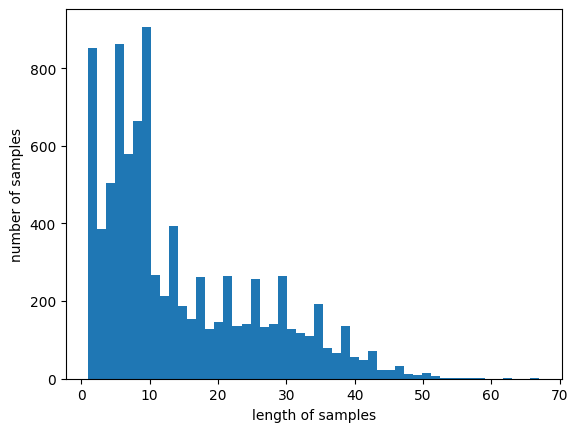

In [26]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in encoded_x_train))
print('샘플의 평균 길이 : %f' % (sum(map(len, encoded_x_train))/len(encoded_x_train)))
plt.hist([len(s) for s in encoded_x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [27]:
def pad_sequences(sentences, max_len):
  features = np.zeros((len(sentences), max_len), dtype=int)
  for index, sentence in enumerate(sentences):
    if len(sentence) !=0:
      features[index,:len(sentence)] = np.array(sentence)[:max_len]
  return features

In [28]:
max_len = 67
padded_x_train = pad_sequences(encoded_x_train, max_len=max_len)
padded_x_valid = pad_sequences(encoded_x_valid, max_len=max_len)
padded_x_test = pad_sequences(encoded_x_test, max_len=max_len)

padded_y_train = pad_sequences(encoded_y_train, max_len=max_len)
padded_y_valid = pad_sequences(encoded_y_valid, max_len=max_len)
padded_y_test = pad_sequences(encoded_y_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_x_train.shape)
print('검증 데이터의 크기 :', padded_x_valid.shape)
print('테스트 데이터의 크기 :', padded_x_test.shape)
print('-' * 35)
print('훈련 데이터의 레이블 :', padded_y_train.shape)
print('검증 데이터의 레이블 :', padded_y_valid.shape)
print('테스트 데이터의 레이블 :', padded_y_test.shape)


훈련 데이터의 크기 : (8985, 67)
검증 데이터의 크기 : (2247, 67)
테스트 데이터의 크기 : (2808, 67)
-----------------------------------
훈련 데이터의 레이블 : (8985, 67)
검증 데이터의 레이블 : (2247, 67)
테스트 데이터의 레이블 : (2808, 67)


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [30]:
class NameEntityRecognizer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=2):
        super(NameEntityRecognizer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        logits = self.fc(lstm_out)
        return logits


In [31]:
X_train_tensor = torch.tensor(padded_x_train, dtype=torch.long)
y_train_tensor = torch.tensor(padded_y_train, dtype=torch.long)
X_valid_tensor = torch.tensor(padded_x_valid, dtype=torch.long)
y_valid_tensor = torch.tensor(padded_y_valid, dtype=torch.long)
X_test_tensor = torch.tensor(padded_x_test, dtype=torch.long)
y_test_tensor = torch.tensor(padded_y_test, dtype=torch.long)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)
valid_dataset = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=False, batch_size=32)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=32)


In [32]:
print('단어 집합의 크기:', len(vocab))


단어 집합의 크기: 16746


In [33]:
embedding_dim = 100
hidden_dim = 256
output_dim = len(tag2index)
learning_rate = 0.01
num_epochs = 10
num_layers = 2


In [34]:
model = NameEntityRecognizer(len(vocab), embedding_dim, hidden_dim, output_dim, num_layers)
model.to('cpu')

NameEntityRecognizer(
  (embedding): Embedding(16746, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [35]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [36]:
def calculate_accuracy(logits, labels, ignore_index=0):
  predicted = torch.argmax(logits, dim=1) #softmax 결과의 최대값
  mask = (labels != ignore_index)
  correct = (predicted==labels).masked_select(mask).sum().item() #맞은 거 개수
  total = mask.sum().item()

  return correct/total

In [39]:
def evaluate(model, valid_dataloader, criterion):
  val_loss = 0
  val_correct = 0
  val_total =0
  model.eval()

  with torch.no_grad():
    for batch_X, batch_y in valid_dataloader:
      batch_X, batch_y = batch_X.to('cpu'), batch_y.to('cpu')

      logits = model(batch_X)

      loss = criterion(logits.view(-1, output_dim), batch_y.view(-1))

      val_loss +=loss.item()
      val_correct += calculate_accuracy(logits.view(-1, output_dim), batch_y.view(-1)) * batch_y.size(0)
      val_total +=batch_y.size(0)

  val_accuracy = val_correct/val_total
  val_loss /= len(valid_dataloader)

  return val_loss, val_accuracy

In [41]:
# Training loop
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        #Forward
        logits = model(batch_X)

        #Loss 계산하기
        loss = criterion(logits.view(-1, output_dim), batch_y.view(-1))

        #optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #학습한 후의 성능
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits.view(-1, output_dim), batch_y.view(-1)) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    #검증 결과
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 검증 결과가 최고인 모델 저장하기
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')


IndexError: index out of range in self